In [1]:
import pandas as pd
import os

data_dirpath = '/usr2/mamille2/tumblr/data/sample1k/'

# Separate out performance on posts that have tags vs posts that don't have tags
Compare performance of (FFN, baseline features) with (FFN, baseline+identity features) separately for posts that have tags vs ones that do not

In [2]:
import numpy as np

# Load predictions from FFN, only baseline features on test set

baseline_preds_fpath = os.path.join(data_dirpath, 'output', 'predictions', 'ffn_baseline_all_test_preds.txt')
# baseline_preds_fpath = os.path.join(data_dirpath, 'output', 'predictions', 'ffn_baseline_all_train_preds.txt')
baseline_preds = np.loadtxt(baseline_preds_fpath)
baseline_preds.shape

(71267,)

In [3]:
# Load predictions from FFN, baseline+identity features on test set

final_preds_fpath = os.path.join(data_dirpath, 'output', 'predictions', 'ffn_labels_baseline+exp1+exp2_all_test_preds.txt')
# final_preds_fpath = os.path.join(data_dirpath, 'output', 'predictions', 'ffn_labels_baseline+exp1+exp2_all_train_preds.txt')
final_preds = np.loadtxt(final_preds_fpath)
final_preds.shape

(71267,)

## Get whether or not post tags was empty for specific instances

In [5]:
from sklearn.model_selection import train_test_split

# Load feature info
reblog_fpath = os.path.join(data_dirpath, 'feature_tables', 'reblog_features.csv')
reblog_features = pd.read_csv(reblog_fpath)
reblog_train, reblog_test = train_test_split(reblog_features, test_size=0.1, random_state=12345)
print(len(reblog_test))
# print(len(reblog_train))

nonreblog_fpath = os.path.join(data_dirpath, 'feature_tables', 'nonreblog_features.csv')
nonreblog_features = pd.read_csv(nonreblog_fpath)
nonreblog_train, nonreblog_test = train_test_split(nonreblog_features, test_size=0.1, random_state=12345)
print(len(nonreblog_test))
# print(len(nonreblog_train))

# Load gold labels
ranking_fpath = os.path.join(data_dirpath, 'feature_tables', 'ranking_labels.csv')
ranking_labels = pd.read_csv(ranking_fpath).iloc[:len(reblog_features)]
labels_train, labels_test = train_test_split(ranking_labels['ranking_label'], test_size=0.1, random_state=12345)
print(len(labels_test))
# print(len(labels_train))

nonreblog_test.columns

71267
71267
71267


Index(['post_id', 'tumblog_id_follower', 'tumblog_id_followee', 'post_tags',
       'post_type', 'post_note_count', 'processed_blog_description_follower',
       'processed_blog_description_followee', 'age_terms_follower',
       'age_terms_followee', 'ethnicity/nationality_terms_follower',
       'ethnicity/nationality_terms_followee', 'fandoms_terms_follower',
       'fandoms_terms_followee', 'gender_terms_follower',
       'gender_terms_followee', 'gender/sexuality_terms_follower',
       'gender/sexuality_terms_followee', 'interests_terms_follower',
       'interests_terms_followee', 'location_terms_follower',
       'location_terms_followee', 'personality type_terms_follower',
       'personality type_terms_followee', 'pronouns_terms_follower',
       'pronouns_terms_followee', 'relationship status_terms_follower',
       'relationship status_terms_followee', 'roleplay_terms_follower',
       'roleplay_terms_followee', 'roleplay/fandoms_terms_follower',
       'roleplay/fandoms_te

In [17]:
type(labels_test)

pandas.core.series.Series

In [19]:
labels_test.iloc[0]

1

In [6]:
type(reblog_test.iloc[0]['post_tags'])

str

In [16]:
len(reblog_test.iloc[0]['post_tags'])

2

In [6]:
# Build merged dataset
lines = []
header = ['actual_label', 'baseline_pred', 'final_pred', 'reblog_post_tag', 'nonreblog_post_tag', 'n_post_tags']
for i in range(len(reblog_test)):
# for i in range(len(reblog_train)):
    actual_label = labels_test.iloc[i]
#     actual_label = labels_train.iloc[i]
    baseline_pred = baseline_preds[i]
    final_pred = final_preds[i]
    reblog_post_tag = len(reblog_test.iloc[i]['post_tags']) > 2
    nonreblog_post_tag = len(nonreblog_test.iloc[i]['post_tags']) > 2
#     reblog_post_tag = len(reblog_train.iloc[i]['post_tags']) > 2
#     nonreblog_post_tag = len(nonreblog_train.iloc[i]['post_tags']) > 2
    n_post_tags = int(reblog_post_tag) + int(nonreblog_post_tag)
    lines.append([actual_label, baseline_pred, final_pred, reblog_post_tag, nonreblog_post_tag, n_post_tags])
    
preds_tags = pd.DataFrame(lines, columns=header)
print(len(preds_tags))
print(preds_tags.columns)

71267
Index(['actual_label', 'baseline_pred', 'final_pred', 'reblog_post_tag',
       'nonreblog_post_tag', 'n_post_tags'],
      dtype='object')


In [7]:
# Split into 3 groups: no post tags, one post tags, both post tags

tag_splits = {}

for n_tags in range(3):
    
    tag_splits[n_tags] = preds_tags[preds_tags['n_post_tags']==n_tags]
    print(f"{n_tags}: {len(tag_splits[n_tags])} ({len(tag_splits[n_tags])/len(preds_tags):.1%})")

0: 43574 (61.1%)
1: 22725 (31.9%)
2: 4968 (7.0%)


In [8]:
# Accuracy for each group

accuracies = {}

# Baseline
print("Baseline")
accuracies['baseline'] = {}
for n_tags in range(3):
    accuracies['baseline'][n_tags] = sum(tag_splits[n_tags]['actual_label'] == tag_splits[n_tags]['baseline_pred'])/len(tag_splits[n_tags])
    print(f"{n_tags}: {accuracies['baseline'][n_tags]}")
    
# Final
print("\nFinal")
accuracies['final'] = {}
for n_tags in range(3):
    accuracies['final'][n_tags] = sum(tag_splits[n_tags]['actual_label'] == tag_splits[n_tags]['final_pred'])/len(tag_splits[n_tags])
    print(f"{n_tags}: {accuracies['final'][n_tags]}")

Baseline
0: 0.6968605131500436
1: 0.8433443344334434
2: 0.8180354267310789

Final
0: 0.7453527332813146
1: 0.8705830583058306
2: 0.8482286634460547


/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


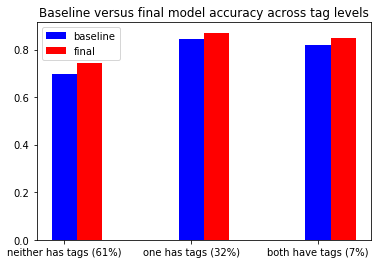

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

# Graph
plt.title("Baseline versus final model accuracy across tag levels")

x = np.array(range(len(accuracies['baseline'])))
# labels = list(accuracies['baseline'].keys())
labels = ['neither has tags (61%)', 'one has tags (32%)', 'both have tags (7%)']
ax = plt.subplot(111)
ax.bar(x, accuracies['baseline'].values(), width=0.2, color='b', align='center')
ax.bar(x+0.2, accuracies['final'].values(), width=0.2, color='r', align='center')
ax.legend(['baseline', 'final'])

plt.xticks(x, labels)
plt.show()